In [1]:
## Importing necessary libraries
import sys
import sqlite3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import normalize, clean_data

In [2]:
# Setting seaborn style
sns.set()

In [3]:
# Getting the transactions data from sqlite
conn = sqlite3.connect("../data/bootcamp_db") # creating connection

In [4]:
# Quering the data from the online_transactions_fixed table
query = """
select *
from online_transactions_fixed
"""
ot = pd.read_sql(query, conn)

In [5]:
online_trans = clean_data(ot)

In [6]:
online_trans.describe()

,old_index,quantity,price,total_order_value,invoice_year,invoice_month,invoice_day,invoice_weekday
count,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000
mean,201388.233230,12.879829,2.905252,21.919158,2010.934356,7.650090,15.011531,2.592034
std,115651.048694,43.577928,7.381186,95.735167,0.247660,3.405954,8.635549,1.920402
min,0.000000,1.000000,0.001000,0.001000,2010.000000,1.000000,1.000000,0.000000
25%,101147.750000,2.000000,1.250000,4.950000,2011.000000,5.000000,7.000000,1.000000
50%,202427.500000,6.000000,1.950000,11.900000,2011.000000,8.000000,15.000000,2.000000
75%,301305.250000,12.000000,3.750000,19.800000,2011.000000,11.000000,22.000000,4.000000
max,399806.000000,4800.000000,1599.260000,38970.000000,2011.000000,12.000000,31.000000,6.000000


In [7]:
# Importing customer data
cust_data = pd.read_csv("../data/customer_data.csv")

In [8]:
cust_data.describe()

,loyalty_time,mean_nstock,mean_nitem,mon_value,frequency,recency
count,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000
mean,133.798917,21.560731,224.903868,371.234784,85.985401,88.463386
std,132.735229,19.285931,305.002619,501.708956,215.913912,98.735861
min,0.000000,1.000000,1.000000,0.850000,1.000000,0.000000
25%,0.000000,9.041667,90.583333,174.022000,16.000000,15.500000
50%,101.000000,16.500000,158.235294,283.120000,39.000000,46.000000
75%,257.000000,28.000000,265.483333,419.060500,94.000000,134.000000
max,373.000000,300.647059,7824.000000,14844.766667,7499.000000,373.000000


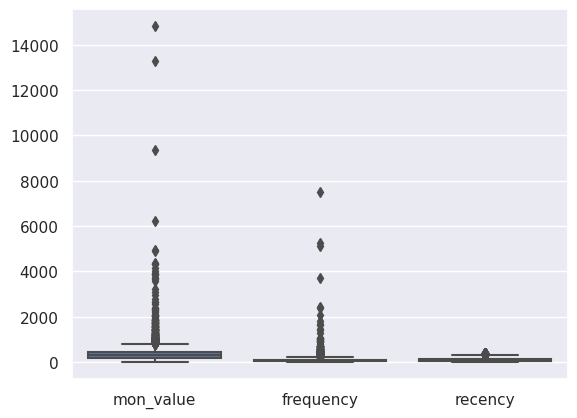

In [9]:
# Let's check the distribution of the RFM attributes
sns.boxplot(cust_data[['mon_value', 'frequency', 'recency']]);

#### It is shown in the plot above that the scales from the three main attributes of the RFM analysis are quite different. As next step, I will normalize them in order to be able to use them to calculate the RFM score

In [10]:
for col in cust_data:
    if col == 'customer_id':
        pass
    else:
        norm = normalize(cust_data[f"{col}"])
        col_name = col + "_norm"
        cust_data[f"{col_name}"] = norm

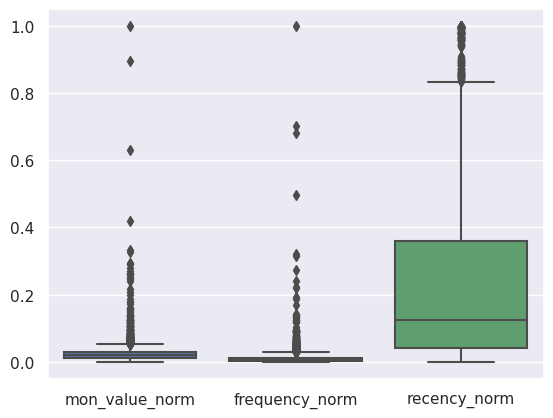

In [11]:
# Let's check the distribution of the RFM attributes this time normalized
sns.boxplot(cust_data[['mon_value_norm', 'frequency_norm', 'recency_norm']]);

#### Monetary value and Frequency are having quite a lot of outliers, they are less spread through the range than Recency. I will define my RFM score as: 

$RFM_{score} = W_{recency} * Recency + W_{frequency} * Frequency + W_{monetary} * Monetary $

$W_{recency}$, $W_{frequency}$ and $W_{monetary}$ will represent the respectively contribution of each attribute to the RFM score.

> <div class="alert alert-block alert-success">
<b>Assumption: </b>Since my data contain transactions puchased on a year, the recency will not be consider as important as the frequency or the monetary value. I will assume that my data comes from transactions on a establish e-commerce, therefore I will focus on the segmentation of my customers giving an extra importance to the monetary value.
</div>

In [12]:
def cust_seg(data, W_R, W_F, W_M):
    # Function to obtain the customers' segments 
    # cust_data is a pandas data frame that contains "recency_norm", "frequency_norm" and mon_value_norm"
    # This are the normalized version of the recency, frequency and monetary value per customer
    # W_R, W_F, W_M are the weights for each attribute
    
    RFM_score = W_R * data['recency_norm'] + W_F * data['frequency_norm'] + W_M * data['mon_value_norm']
    data['RFM_score'] = RFM_score # adding RFM score to the customer dataset
    
    segment = []
    Q1, Q2, Q3 = RFM_score.quantile([0.25, .40, 0.75])
    
    for score in RFM_score:
        if score <= Q1:
            segment.append("A")
        elif Q1 < score <= Q2:
            segment.append("A")
        elif Q2 < score <= Q3:
            segment.append("B")
        else:
            segment.append("C")

    data['cust_segment'] = segment
    
    return data

In [13]:
cust_seg(cust_data, 0.6, 0.1, 0.3)

,customer_id,loyalty_time,mean_nstock,mean_nitem,mon_value,frequency,recency,loyalty_time_norm,mean_nstock_norm,mean_nitem_norm,mon_value_norm,frequency_norm,recency_norm,RFM_score,cust_segment
0,u12347,365,26.000000,351.142857,615.714286,182.0,1,0.978552,0.083431,0.044758,0.041422,0.024140,0.002681,0.016449,A
1,u12348,282,6.750000,583.000000,359.310000,27.0,74,0.756032,0.019189,0.074396,0.024149,0.003468,0.198391,0.126626,B
2,u12349,0,72.000000,630.000000,1457.550000,72.0,18,0.000000,0.236945,0.080404,0.098134,0.009469,0.048257,0.059342,B
3,u1235,0,16.000000,196.000000,294.400000,16.0,309,0.000000,0.050059,0.024926,0.019776,0.002001,0.828418,0.503184,C
4,u12352,260,11.000000,75.142857,197.962857,77.0,35,0.697051,0.033373,0.009478,0.013279,0.010136,0.093834,0.061298,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4242,u1828,0,10.000000,45.000000,180.600000,10.0,277,0.000000,0.030035,0.005624,0.012109,0.001200,0.742627,0.449329,C
4243,u18281,0,7.000000,54.000000,80.820000,7.0,180,0.000000,0.020024,0.006775,0.005387,0.000800,0.482574,0.291240,C
4244,u18282,114,6.000000,51.500000,89.025000,12.0,7,0.305630,0.016686,0.006455,0.005940,0.001467,0.018767,0.013189,A
4245,u18283,333,44.937500,84.687500,127.473750,719.0,3,0.892761,0.146631,0.010698,0.008530,0.095759,0.008043,0.016961,A


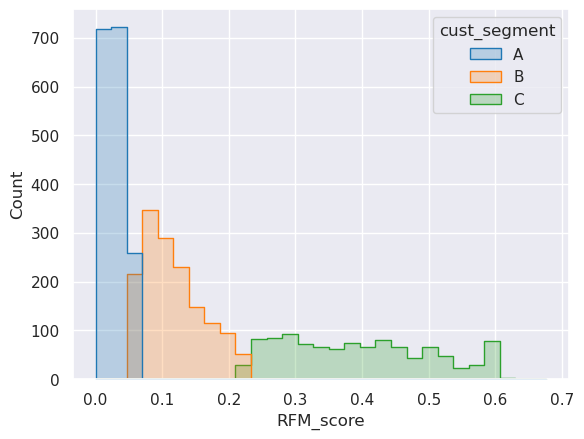

In [14]:
p = sns.histplot(data=cust_data, x='RFM_score', hue='cust_segment', element="step", palette="tab10")

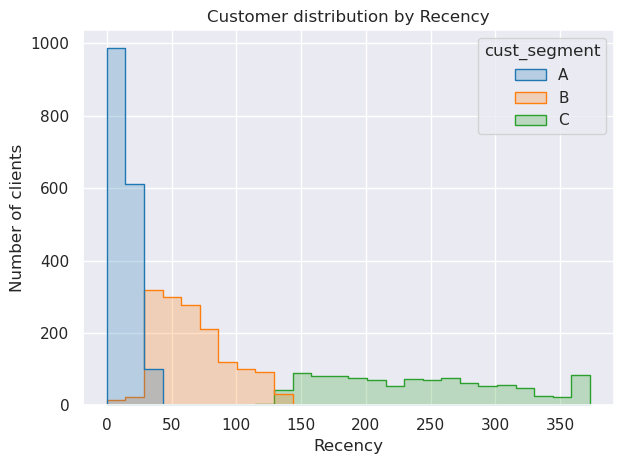

In [15]:
# Customer distribution by recency and segment
sns.histplot(data=cust_data, x='recency', hue='cust_segment', element="step", palette="tab10")
plt.title("Customer distribution by Recency")
plt.xlabel("Recency")
plt.ylabel("Number of clients")
plt.tight_layout()

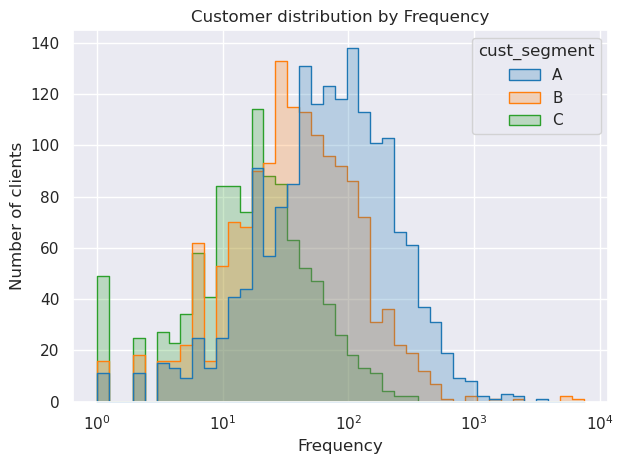

In [16]:
# Customer distribution by frequency and segment
sns.histplot(data=cust_data, x='frequency', hue='cust_segment', element="step", palette="tab10", log_scale=True)
plt.title("Customer distribution by Frequency")
plt.xlabel("Frequency")
plt.ylabel("Number of clients")
plt.tight_layout()

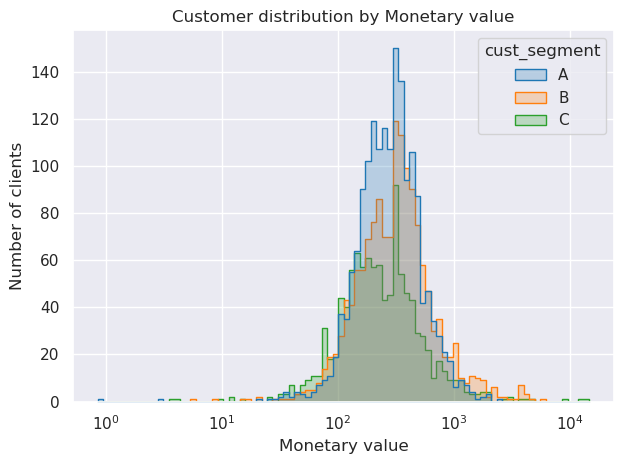

In [17]:
# Customer distribution by monetary value and segment
sns.histplot(data=cust_data, x='mon_value', hue='cust_segment', element="step", palette="tab10", log_scale=True)
plt.title("Customer distribution by Monetary value")
plt.xlabel("Monetary value")
plt.ylabel("Number of clients")
plt.tight_layout()

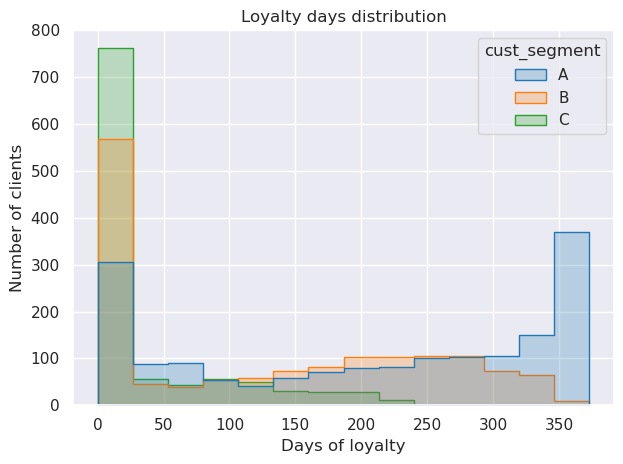

In [18]:
sns.histplot(data=cust_data, x='loyalty_time', hue='cust_segment', element="step", palette="tab10")
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()

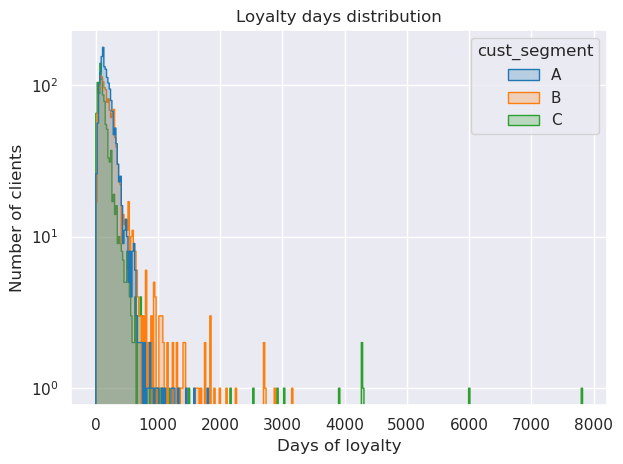

In [19]:
p = sns.histplot(data=cust_data, x='mean_nitem', hue='cust_segment', element="step", palette="tab10")
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
p.set_yscale('log')
plt.tight_layout()

#### Let's merge the customer data with the online transactions dataset to get the transactions labelled with the corresponding customer segment

In [20]:
# Mergind online transactions dataset with customer dataset
merged_df = pd.merge(online_trans, cust_data, on='customer_id', how='left')

In [21]:
merged_df.head(10)

,old_index,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,total_order_value,...,frequency,recency,loyalty_time_norm,mean_nstock_norm,mean_nitem_norm,mon_value_norm,frequency_norm,recency_norm,RFM_score,cust_segment
0,0,536373,82494L,WOODEN FRAME ANTIQUE WHITE,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,...,297.0,301,0.190349,0.025815,0.006388,0.010625,0.039477,0.806971,0.491317,C
1,1,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,...,2366.0,0,1.000000,0.083431,0.053457,0.044829,0.315417,0.000000,0.044991,A
2,2,536381,22438,BALLOON ART MAKE YOUR OWN FLOWERS,1,2010-12-01 09:41:00,1.95,u15311,United Kingdom,1.95,...,2366.0,0,1.000000,0.083431,0.053457,0.044829,0.315417,0.000000,0.044991,A
3,3,536384,22189,CREAM HEART CARD HOLDER,4,2010-12-01 09:53:00,3.95,u18074,United Kingdom,15.80,...,13.0,373,0.000000,0.040047,0.024160,0.032926,0.001600,1.000000,0.610038,C
4,4,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,u12431,Australia,32.70,...,192.0,35,0.906166,0.045951,0.024199,0.027759,0.025473,0.093834,0.067175,B
5,5,536390,22960,JAM MAKING SET WITH JARS,12,2010-12-01 10:19:00,3.75,u17511,United Kingdom,45.00,...,949.0,2,0.991957,0.102231,0.268946,0.198804,0.126434,0.005362,0.075502,B
6,6,536390,21080,SET/20 RED RETROSPOT PAPER NAPKINS,96,2010-12-01 10:19:00,0.64,u17511,United Kingdom,61.44,...,949.0,2,0.991957,0.102231,0.268946,0.198804,0.126434,0.005362,0.075502,B
7,7,536392,21891,TRADITIONAL WOODEN SKIPPING ROPE,12,2010-12-01 10:29:00,1.25,u13705,United Kingdom,15.00,...,28.0,7,0.981233,0.027810,0.015339,0.015928,0.003601,0.018767,0.016399,A
8,8,536394,22558,CLOTHES PEGS RETROSPOT PACK 24,48,2010-12-01 10:39:00,1.25,u13408,United Kingdom,60.00,...,471.0,1,0.991957,0.022431,0.033443,0.030556,0.062683,0.002681,0.017044,A
9,9,536396,82494L,WOODEN FRAME ANTIQUE WHITE,12,2010-12-01 10:51:00,2.55,u1785,United Kingdom,30.60,...,297.0,301,0.190349,0.025815,0.006388,0.010625,0.039477,0.806971,0.491317,C


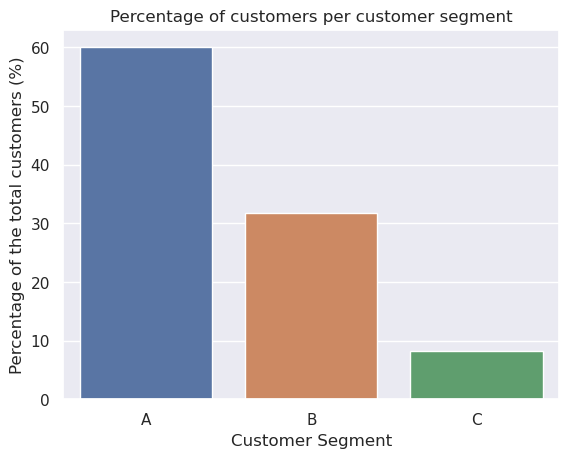

In [22]:
# Number of customers per segment 
cust_segm = merged_df.groupby("cust_segment")['customer_id']
sns.barplot(x=cust_segm.count().index, y= cust_segm.count().values / merged_df.shape[0] * 100)
plt.xlabel("Customer Segment")
plt.ylabel("Percentage of the total customers (%)")
plt.title("Percentage of customers per customer segment");

### There is a considerably high amount of customers in the segment A. For the moment, I will analyse the data with this three segments. In the future, I will try to balance the number of customer in each segment. 

In [23]:
# Number of invoices per month
monthly_data = merged_df.groupby(["cust_segment", "invoice_month", "invoice_year"]).count()['invoice'].reset_index()

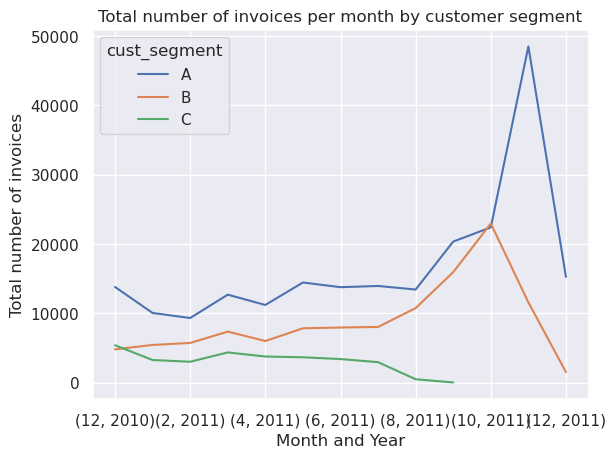

In [45]:
monthly_data.pivot_table('invoice', index=['invoice_month', 'invoice_year'], columns='cust_segment', aggfunc='sum').sort_values(by='invoice_year').plot(kind='line')
plt.xlabel("Month and Year")
plt.ylabel("Total number of invoices")
plt.title("Total number of invoices per month by customer segment");

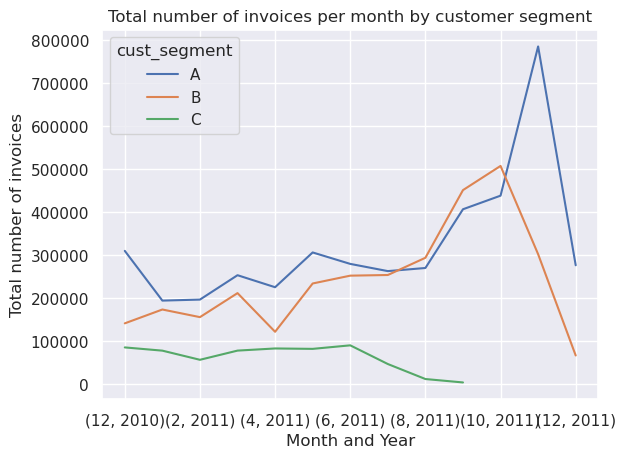

In [47]:
# Number of invoices per month
monthly_data = merged_df.groupby(["cust_segment", "invoice_month", "invoice_year"])['total_order_value'].sum().reset_index()
monthly_data.pivot_table('total_order_value', index=['invoice_month', 'invoice_year'], columns='cust_segment', aggfunc='sum').sort_values(by='invoice_year').plot(kind='line')
plt.xlabel("Month and Year")
plt.ylabel("Total number of invoices")
plt.title("Total number of invoices per month by customer segment");

In [25]:
ordered_days = merged_df[['invoice_weekday', 'invoice_dayname']].sort_values(by='invoice_weekday')['invoice_dayname'].unique()

In [26]:
# Getting the number of invoices per day of the week
weekly_inv = merged_df.groupby(["cust_segment", "invoice_weekday", 'invoice_dayname']).count()['invoice'].reset_index().sort_values(by='invoice_weekday')

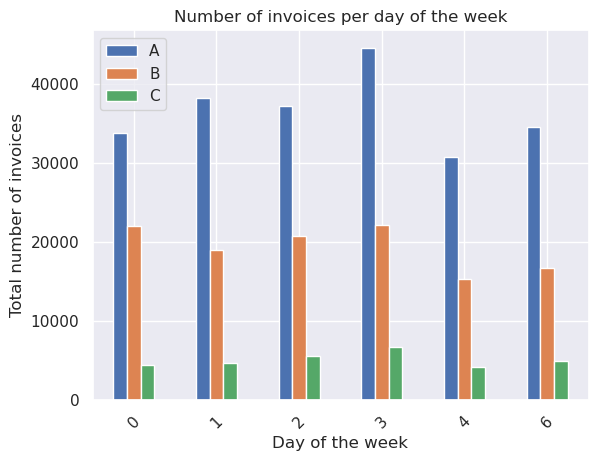

In [27]:
weekly_inv.pivot_table('invoice', index=['invoice_weekday'], columns='cust_segment', aggfunc='sum').plot(kind='bar')
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Total number of invoices")
plt.xticks(rotation=45)
plt.legend(loc='upper left');

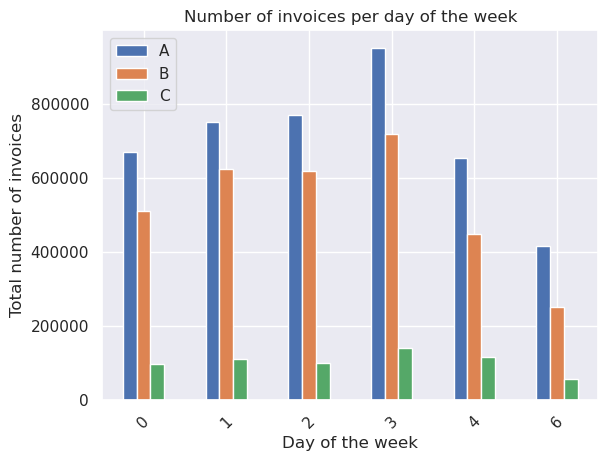

In [42]:
weekly_inv = merged_df.groupby(["cust_segment", "invoice_weekday", 'invoice_dayname'])['total_order_value'].sum().reset_index().sort_values(by='invoice_weekday')
weekly_inv.pivot_table('total_order_value', index=['invoice_weekday'], columns='cust_segment', aggfunc='sum').plot(kind='bar')
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Total number of invoices")
plt.xticks(rotation=45)
plt.legend(loc='upper left');

#### The number of invoices per day of the week is relatively stable for each customer segment

In [38]:
daily_inv = merged_df.groupby(["cust_segment", "invoice_day"]).count()['invoice'].reset_index()

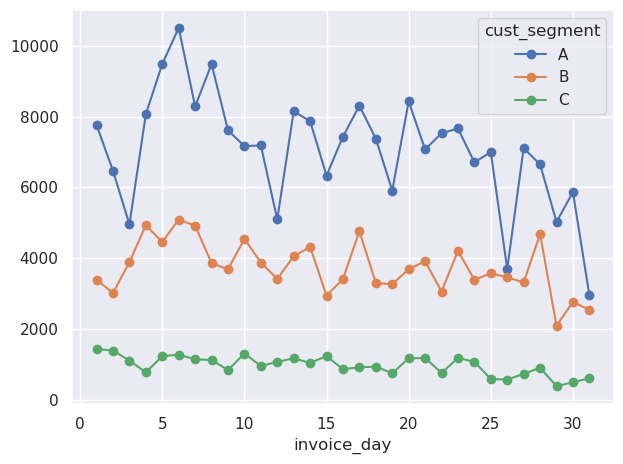

In [39]:
daily_inv.pivot_table('invoice', index=['invoice_day'], columns='cust_segment', aggfunc='sum')
.plot(kind='line', marker='o')
plt.tight_layout();

#### In the previous plot it is clear that our customers are segmented in three main groups. A represents the customers that are purchasing the most and therefore generating more income to the company. Segment B represents the customers with mid value and C the ones purchasing the least.

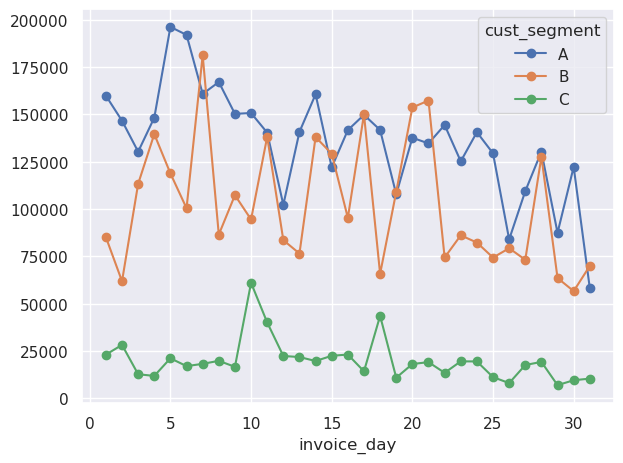

In [32]:
tot_val_daily = merged_df.groupby(["cust_segment", "invoice_day"])['total_order_value'].sum().reset_index()
tot_val_daily .pivot_table('total_order_value', index=['invoice_day'], columns='cust_segment', aggfunc='sum').plot(kind='line', marker='o')
plt.tight_layout();

#### Even though the customer in segment A tend to purchase more thant customers in segment B, in the plot above is shown that the total order value for customers within these groups are comparable

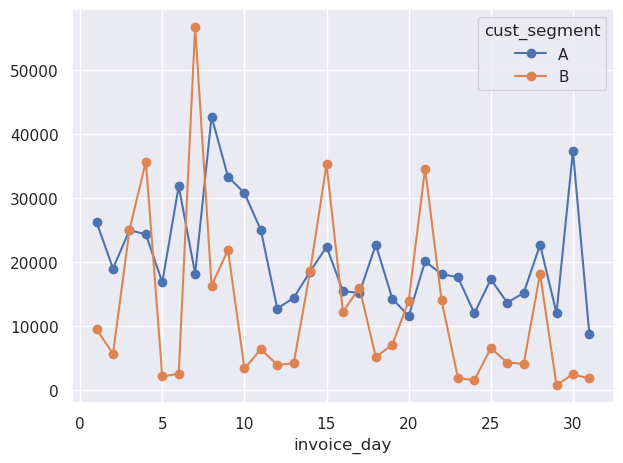

In [54]:
tot_val_daily = merged_df[merged_df['recency_norm'] == 0].groupby(["cust_segment", "invoice_day"])['total_order_value'].sum().reset_index()
tot_val_daily .pivot_table('total_order_value', index=['invoice_day'], columns='cust_segment', aggfunc='sum').plot(kind='line', marker='o')
plt.tight_layout();